# Imports

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection
import seaborn as sns

In [2]:
kickstarter = pd.read_csv("/data/royzawadzki/kickstarter.csv", parse_dates = ["deadline", "launched"])

In [3]:
kickstarter.dtypes

Unnamed: 0                  int64
ID                          int64
name                       object
category                   object
main_category              object
currency                   object
deadline           datetime64[ns]
goal                      float64
launched           datetime64[ns]
pledged                   float64
state                      object
backers                     int64
country                    object
usd pledged               float64
goal_log                  float64
backers_log               float64
usd pledged_log           float64
duration                    int64
season                     object
month                      object
month_number                int64
season_number               int64
dtype: object

# Features

In [4]:
X = kickstarter[["category", "main_category", "country", "goal_log",
                       "backers_log", "usd pledged_log", "duration", "season", "month"]]
assert list(X.columns) == ["category", "main_category", "country", "goal_log",
                       "backers_log", "usd pledged_log", "duration", "season", "month"]

### Creation of Dummy Variables for the Feature Array

In [5]:
columns_before_dummies = len(X.columns)
dummies_X = pd.get_dummies(X, columns = ["category", "main_category","country", "season", "month"], drop_first = True)
dummies_X = dummies_X.drop(["goal_log", "backers_log", "usd pledged_log", "duration"], axis = 1)
X = pd.concat([X, dummies_X], axis = 1)
X = X.drop(columns = ["category", "main_category","country", "usd pledged_log", "backers_log", "season", "month"], axis = 1)

I decided to drop money raised and backers from the features array because it defeats the purpose of this model, which is to predict success or failure before the kickstarter ends. Knowing money raised and total backers at the end gives us part of the answer and is unrealistic for our model to know if used in real time. This would explain why including it gave an accuracy of 0.9361496507019375, which is fairly high.

In [6]:
num_category = len(kickstarter["category"].unique())
num_maincat = len(kickstarter["main_category"].unique())
num_country = len(kickstarter["country"].unique())
num_seasons = 4
num_months = 12
num_cols_numeric = 2
assert len(X.columns) == (num_cols_numeric + num_category - 1 + num_maincat - 1 + num_country - 1 +
                         num_seasons - 1 + num_months -1)

In [7]:
X.head()

,goal_log,duration,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,category_Apps,...,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
0,10.308953,59,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,10.714418,44,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,8.517193,29,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,10.819778,34,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,6.907755,19,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


# Target

In [8]:
y = kickstarter[["state"]]

Before using our model, the column that encodes success and failure transformed to be integers. In this case, "Failed" = 0 and "Success" = 1.

In [9]:
def state_to_int(x):
    if x == "successful":
        return 1
    elif x == "failed":
        return 0

y = y["state"].apply(state_to_int)
ysum = y.sum()
assert list(y.unique()) == [0,1]
assert ysum == len(kickstarter[kickstarter["state"] == "successful"])

# Train/test Split

We will be using a 70%-30% train to test split

In [10]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = .3, train_size = .7, random_state = 15)

# Model 1: Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### Creation of Model, Hyperparameter Tuning, Cross Validation, and Prediction

**Note: the following cells may take more than a few minutes to run**

In [222]:
#Creating parameter grid of C for grid search
c_space = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = {"C": c_space}

#Grid search and training
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, param_grid, cv = 5)
logreg_cv.fit(X_train,y_train)

#Predicting the Data
y_pred_lr = logreg_cv.predict(X_test)

In [223]:
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameter: {'C': 1}
Best score is 0.6558681560455039


Our accuracy is not great: only about 15% higher than guessing success or failure by flipping a coin. In addition, the best parameter we found for $C$ out of our values used for hyperparameter tuning was 10. $C$ is the regularization parameter which applies a penalty to increasing the magnitude of paramater values in order to reduce overfitting.

### Visualization of Probabilities Computed by the Logistic Regression

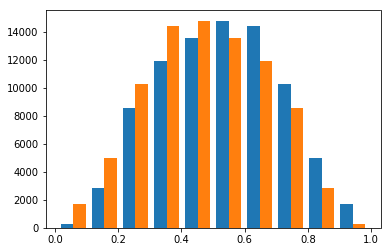

In [224]:
probs = logreg_cv.predict_proba(X_test)
plt.hist(probs)
#plt.legend()
plt.show()

We can see in the above histogram that the majority of the probabilities that the logistic regression are around .5. This means that the model is having trouble with assigning high and low probabilities to the probability of success (blue) or the probability of failure (orange) for many of the observations.

### Confusion Matrix and Classification Report

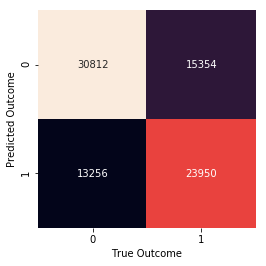

In [225]:
confusion_matrix_logistic = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(confusion_matrix_logistic.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel("True Outcome")
plt.ylabel("Predicted Outcome")
plt.show()

In [226]:
print(classification_report(y_test, y_pred_lr))

             precision    recall  f1-score   support

          0       0.67      0.70      0.68     44068
          1       0.64      0.61      0.63     39304

avg / total       0.66      0.66      0.66     83372



Overall, our model was barely satisfactory. This may be due to the seemingly random nature of the success Kickstarter Campaigns that adds difficultly in generalizing from the predictors that were avaliable. The limiting factor in the success of this model was most likely that there is a lot more that goes into the success of a kickstarter that we do not have such as how it was advertised.

# Model 2: Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

### Samping from the Original Data and Test/Train Splitting the Sample

Due to the immense running time of fitting the best random forest model using full dataset, we will use a sample from the original dataset to train and test the data.

In [24]:
kickstarter_sample = kickstarter.sample(80000)

X_samp = kickstarter_sample[["category", "main_category", "country", "goal_log",
                       "backers_log", "usd pledged_log", "duration"]]

dummies_X_samp = pd.get_dummies(X_samp, columns = ["category", "main_category","country"], drop_first = True)
dummies_X_samp = dummies_X_samp.drop(["goal_log", "backers_log", "usd pledged_log", "duration"], axis = 1)
X_samp = pd.concat([X_samp, dummies_X_samp], axis = 1)
X_samp = X_samp.drop(columns = ["category", "main_category","country", "usd pledged_log", "backers_log"], axis = 1)

y_samp = kickstarter_sample[["state"]]
y_samp = y_samp["state"].apply(state_to_int)

X_train_samp, X_test_samp, y_train_samp, y_test_samp = sklearn.model_selection.train_test_split(X_samp, y_samp, test_size = .3, train_size = .7, random_state = 15)

## Random Forest Model with no Hyperparameter Tuning and Using Sample

Since hyperparameter tuning was taking too long to run, we are not constructing our model with hyperparameters.

**Note: the following two cells will take more than a few minutes to run**

In [25]:
random_forest_no_hyper = RandomForestClassifier(n_estimators=300, random_state=12)
random_forest_no_hyper.fit(X_train_samp, y_train_samp)
ypred_rf_no_hyper = random_forest_no_hyper.predict(X_test_samp)

In [27]:
cv_score_samp = cross_val_score(random_forest_no_hyper, X_samp, y_samp, cv=5)
print("Mean: {0}, Standard Deviation: {1}".format(cv_score_samp.mean(), cv_score_samp.std()))

Mean: 0.6181875611241702, Standard Deviation: 0.002743225489291695


The accuracy is relatively similar to the logistic regression. The difference in the accuracies can be explained by the fact that the random forest model was trained with a sample of the data as opposed to the full dataset.

In [36]:
features = pd.DataFrame({'feature': X_samp.columns, 'importance': random_forest_no_hyper.feature_importances_})

features.sort_values('importance', ascending=False, inplace=True)
features[0:10]

,feature,importance
0,goal_log,0.478753
1,duration,0.264157
194,country_US,0.010485
169,main_category_Music,0.009865
182,country_GB,0.008248
137,category_Tabletop Games,0.007870
172,main_category_Technology,0.006501
176,country_CA,0.006327
149,category_Video Games,0.005143
9,category_Apps,0.004829


The most important feature was goal_log followed by duration.

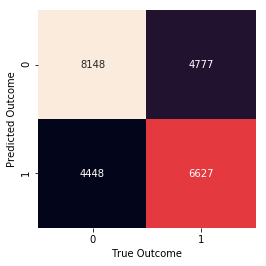

In [39]:
confusion_matrix_rfno = confusion_matrix(y_test_samp, ypred_rf_no_hyper)
sns.heatmap(confusion_matrix_rfno.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel("True Outcome")
plt.ylabel("Predicted Outcome")
plt.show()

In [42]:
print(classification_report(y_test_samp, ypred_rf_no_hyper))

             precision    recall  f1-score   support

          0       0.63      0.65      0.64     12596
          1       0.60      0.58      0.59     11404

avg / total       0.62      0.62      0.62     24000



Overall, this model was no better than our logistic regression which puts them to be tied for these purposes. Perhaps if we had more features than we already had such as information about their marketing or tier rewards one model would pull ahead of the other.